## Packages Installation:

In [3]:

pip install timm

Note: you may need to restart the kernel to use updated packages.


In [4]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
import copy
import requests
import io 
import timm 
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, f1_score
from torch.nn import CrossEntropyLoss
plt.ion()


In [5]:
device_compact = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device_compact)

cpu


In [6]:
vit_models_project = timm.list_models('*vit*', pretrained=True)
vit_models_project

['convit_base.fb_in1k',
 'convit_small.fb_in1k',
 'convit_tiny.fb_in1k',
 'crossvit_9_240.in1k',
 'crossvit_9_dagger_240.in1k',
 'crossvit_15_240.in1k',
 'crossvit_15_dagger_240.in1k',
 'crossvit_15_dagger_408.in1k',
 'crossvit_18_240.in1k',
 'crossvit_18_dagger_240.in1k',
 'crossvit_18_dagger_408.in1k',
 'crossvit_base_240.in1k',
 'crossvit_small_240.in1k',
 'crossvit_tiny_240.in1k',
 'davit_base.msft_in1k',
 'davit_small.msft_in1k',
 'davit_tiny.msft_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'efficientvit_b1.r256_in1k',
 'efficientvit_b1.r288_in1k',
 'efficientvit_b2.r224_in1k',
 'efficientvit_b2.r256_in1k',
 'efficientvit_b2.r288_in1k',
 'efficientvit_b3.r224_in1k',
 'efficientvit_b3.r256_in1k',
 'efficientvit_b3.r288_in1k',
 'efficientvit_l1.r224_in1k',
 'efficientvit_l2.r224_in1k',
 'efficientvit_l2.r256_in1k',
 'efficientvit_l2.r288_in1k',
 'efficientvit_l2.r384_in1k',
 'efficientvit_l3.r224_in1k',
 'efficientvit_l3.r256_in1k',
 'efficientvit_l3.r320_in1

In [7]:
from IPython.display import HTML, display
def progress_bar(current_value, total_value=100):
    return HTML(""" 
                <progress
                 value='{current}' 
                max='{total}', 
                style='width: 100%'>
                {current} 
                </progress> 
                """.format(current=current_value, total=total_value))

## Importing & Labelling Dataset

In [8]:
project_dataset_path = "C:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Chest_xray_Corona_Metadata.csv"
project_dataset_path = pd.read_csv(project_dataset_path)
project_dataset_path.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [9]:
normal_data = project_dataset_path[project_dataset_path["Label"] == "Normal"]
virus_data = project_dataset_path[project_dataset_path["Label_1_Virus_category"] == "Virus"]
print(normal_data.shape[0], virus_data.shape[0])
print(project_dataset_path.shape)
#print(normal_data)
#print(virus_data)

1576 1555
(5910, 5)


In [11]:
dataset_path = "C:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Dataset\\Data"
normal_images_path = f"{dataset_path}//normal"
virus_images_path = f"{dataset_path}//virus"

directory_mapping = {
    normal_images_path: normal_data,
    virus_images_path: virus_data,
}

#print(directory_mapping)

for directory in directory_mapping.keys():
    if not os.path.exists(directory):
        os.mkdir(directory)
        
old_data_path = "c:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Dataset\\Chest-XRay-Dataset"

for current_dir, metadata in directory_mapping.items():
    #print(directory)
    for img_name in metadata["X_ray_image_name"]:
        if os.path.exists(f"{old_data_path}/train/{img_name}"):
            os.rename(f"{old_data_path}/train/{img_name}", f"{current_dir}/{img_name}")
        elif os.path.exists(f"{old_data_path}/test/{img_name}"):
            os.rename(f"{old_data_path}/test/{img_name}", f"{current_dir}/{img_name}")


## Loading Dataset

In [12]:
input_size = 3, 128, 128
image_size = 128
num_output_classes = 2
batch_size = 32
interpolation = 'bicubic'
IMAGENET_DEFAULT_MEAN  = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
DEFAULT_CROP_PCT = 0.9

### Creating Dataset and DataLoader



#### Option2: Use same dataset and dataloader as BiT experiment:

In [14]:
dataload_dir = "C:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Dataset\\Data"
dataload_transforms = transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ])
img_datasets = datasets.ImageFolder(dataload_dir, dataload_transforms)

In [15]:
dataset_imgsizes = len(img_datasets)
class_labels = img_datasets.classes
print(dataset_imgsizes, class_labels)

1141 ['normal', 'virus']


In [16]:
val_size = int(dataset_imgsizes*0.15)
train_dataset, value_dataset, test_dataset = torch.utils.data.random_split(img_datasets, [dataset_imgsizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
train_length, val_length = len(train_dataset), len(value_dataset)
print(len(train_dataset))
print(len(value_dataset))
print(len(test_dataset))

799
171
171


In [17]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(value_dataset, batch_size=batch_size, shuffle=False)

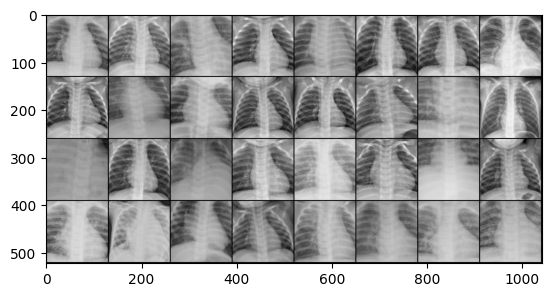

In [18]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
inputs, classes = next(iter(loader_train))
out = tv.utils.make_grid(inputs)
imshow(out)


## Fine-Tuning:

In [27]:
def eval_corona(model, loader_val):
  model.eval()
  preds = []
  val_len = len(loader_val.dataset)
  print(val_len)
  with torch.no_grad():
    for x, t in loader_val:
      x, t = x.to(device_compact), t.to(device_compact)
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / val_len

In [33]:
model = timm.create_model('vit_base_resnet50_224_in21k', pretrained=True, num_classes=num_output_classes, img_size=image_size)
model.to(device_compact)

VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (drop): Identity()
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

### Use the Default Optimizer, Loss_Function and LR_Scheduler as Train.py in the Code Source:

In [34]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [35]:
from timm.scheduler import StepLRScheduler
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1)
start_epoch = 0
num_epochs =15
noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

### Training and Evaluating the Model:

In [36]:
iters = 15

pb_train = display(progress_bar(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device_compact), t.to(device_compact)
    logits = model(x)
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_length
  accus_train.append([])

  lr_scheduler.step(i + 1)

  accus_val.append(eval_corona(model, loader_val))
  model.train()

  pb_train.update(progress_bar(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        , flush=True)

171
[Step 1] loss=1.26e+01 train accu=84.73% validation accu=95.91% 
171
[Step 2] loss=1.82e+01 train accu=58.57% validation accu=51.46% 
171
[Step 3] loss=1.57e+01 train accu=69.59% validation accu=94.74% 
171
[Step 4] loss=1.12e+01 train accu=85.36% validation accu=93.57% 
171
[Step 5] loss=9.84e+00 train accu=89.49% validation accu=94.74% 
171
[Step 6] loss=8.62e+00 train accu=91.36% validation accu=93.57% 
171
[Step 7] loss=7.89e+00 train accu=93.37% validation accu=93.57% 
171
[Step 8] loss=8.41e+00 train accu=91.61% validation accu=95.32% 
171
[Step 9] loss=7.58e+00 train accu=93.37% validation accu=94.15% 
171
[Step 10] loss=7.17e+00 train accu=94.74% validation accu=94.15% 
171
[Step 11] loss=7.52e+00 train accu=92.99% validation accu=95.32% 
171
[Step 12] loss=6.70e+00 train accu=96.37% validation accu=95.91% 
171
[Step 13] loss=6.49e+00 train accu=96.37% validation accu=94.15% 
171
[Step 14] loss=6.19e+00 train accu=97.50% validation accu=94.74% 
171
[Step 15] loss=6.35e+00 t

## Model Testing:

In [37]:

model.eval()
criterion = CrossEntropyLoss()
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
preds = []
test_loss = 0.0
test_loss1 = 0.0

with torch.no_grad():
    for x, t in loader_test:
        x, t = x.to(device_compact), t.to(device_compact)
        logits = model(x)
        loss_test = criterion(logits, t)
        loss_11 = loss_fn(logits, t)
        test_loss1 += loss_11.detach().cpu().item() / len(test_dataset)
        test_loss += loss_test.detach().cpu().item() / len(test_dataset)
        preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

accur_test = sum(preds) / len(test_dataset)
print(accur_test)
print(accur_test.detach().cpu().item(), f"test_loss: {test_loss:.2f}", f"test_loss1: {test_loss1:.2f}")

tensor(0.8947)
0.8947368264198303 test_loss: 0.01 test_loss1: 0.01


## Getting true and predicted values:


In [38]:
y_true = []
y_pred = []

with torch.no_grad():
    for x, t in loader_test:
        x, t = x.to(device_compact), t.to(device_compact)
        outputs = model(x)
        output = torch.max(torch.exp(outputs), 1)[1]
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs)  # Save Prediction
        y_true.extend(t.data.cpu().numpy())

print(y_true)
print(y_pred)


[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,

## Performance Evaluation:


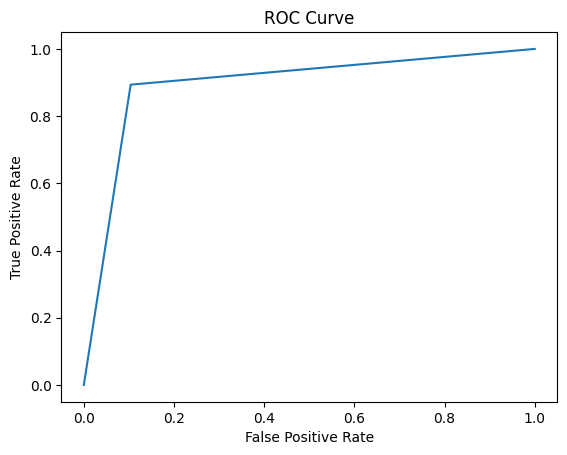

F1 Score: 0.9032258064516129
Sensitivity Score: 0.8961038961038961
Specificity Score: 0.8936170212765957


In [41]:
def roc_plot(y_true, y_prob):
 fpr, tpr, _ = roc_curve(y_true, y_prob)
 plt.plot(fpr, tpr)
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
 plt.title('ROC Curve')
 plt.show()

def f1(y_true, y_pred):
 f1 = f1_score(y_true, y_pred)
 return f1.item()

def sensitivity(y_true, y_pred):
 cm = confusion_matrix(y_true, y_pred)
 return cm[0, 0] / (cm[0, 0] + cm[0, 1])

def specificity(y_true, y_pred):
 cm = confusion_matrix(y_true, y_pred)
 return cm[1, 1] / (cm[1, 0] + cm[1, 1])

roc_plot(y_true, y_pred)
f = f1(y_true, y_pred)
print("F1 Score:", f)
sens = sensitivity(y_true, y_pred)
print("Sensitivity Score:", sens)
spec = specificity(y_true, y_pred)
print("Specificity Score:", spec)


## Save Model Path:

In [43]:
save_model_path = "C:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Model Path\\vit_model_best.pth"
torch.save(model, save_model_path)